
Section Z: Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.signal import convolve2d
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import torchvision
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm_notebook

Section A: Dataset Loading

In [ ]:
def MNIST_loaders(train_batch_size, test_batch_size):
    mu_mnist = 0.1307
    sig_mnist = 0.3081
    # In PyTorch, a transform object is an instance of a class that defines a data transformation
    transform = Compose([
        ToTensor(), # Convert data to tensor
        Normalize((mu_mnist,), (sig_mnist,)), # Normalise data
        Lambda(lambda x: torch.flatten(x)) # flatten data
        ])

    train_loader = DataLoader(
        MNIST('./data/', train=True, download=True, transform=transform),
        batch_size=train_batch_size, shuffle=True
        )
        # shuffling is not important in evaluation!

    test_loader = DataLoader(
        MNIST('./data/', train=False, download=True, transform=transform),
        batch_size=test_batch_size, shuffle=False
        )
    """ DataLoader object description
     The primary purpose of a DataLoader is to take a dataset and provide batches of data to the model.
     It handles the process of creating batches, shuffling the data (if specified),
     and parallelizing data loading using multiple workers to improve efficiency.
    """
    return train_loader, test_loader

train_loader, test_loader = MNIST_loaders(50000, 10000)



100%|██████████| 9912422/9912422 [00:00<00:00, 102684727.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 116141604.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30847936.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4190613.46it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Section B: Generating Data

In [ ]:
def overlay_labels_on_images(images, labels):
    """Replace the first 10 pixels of images with one-hot-encoded labels
    """
    num_images = images.shape[0] # Get the number of images in the batch
    data = images.clone() # Clone the input images to avoid modifying the original data

    data[:, :10] *= 0.0 # Set the values of the first 10 pixels to 0.0

    # For each image, set the pixel corresponding to the one-hot-encoded label to the maximum value in the original image
    data[range(num_images), labels] = images.max()
    return data


images_train, labels_train = next(iter(train_loader)) # converts the train_loader into an iterator
images_train, labels_train = images_train.cuda(), labels_train.cuda() # Move to GPU
images_test, labels_test = next(iter(test_loader)) # test data
images_test, labels_test = images_test.cuda(), labels_test.cuda() # Move to GPU

images_pos = overlay_labels_on_images(images_train, labels_train)
# Generate negative data
rnd = torch.randperm(images_train.size(0))
images_neg = overlay_labels_on_images(images_train, labels_train[rnd])


Section C: Implement Network

تابع لاس نوشته شده را میتوان به دو بخش تقسیم کرد. یک بخش برای دیتاهای مثبت و دیگری برای دیتاهای منفی. هرچقدر گودنس برای داده های مثبت بیشتر از ترشولد و برای داده های منفی کمتر از ترشولد باشد لاس کمتر میشود و میزان جریمه کمتر میشود. پس میتوان گفت هدف از این لاس بیشینه کردن گودنس برای داده های مثبت و کمینه کردن آن برای داده های منفی است.

In [ ]:
class Net(nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]
    """
    The paper mentions some techniques like accumulating "goodness" scores for each
    possible class label and picking the one with the highest score. We could use
    this goodness measure to get a predicted label and compare to the true label.
    """

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = overlay_labels_on_images(x, label)
            layers_goodness = []
            for layer in self.layers:
                h = layer.forward(h)
                layers_goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(layers_goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        itr_pos = x_pos.clone()
        itr_neg = x_neg.clone()
        for layer in self.layers:
            itr_pos, itr_neg = layer.train(itr_pos, itr_neg)

class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 800

    def forward(self, x):
        xn = x / (1e-5 + x.norm(2, 1, keepdim=True))
        xn = x / x.size(1)
        nxt = torch.mm(xn, self.weight.T) + self.bias.unsqueeze(0)
        return self.relu(nxt)


    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
          # goodness for each data
            g_pos = self.forward(x_pos).pow(2).sum(1)
            g_neg = self.forward(x_neg).pow(2).sum(1)
          # loss for each data
            lp = torch.log(1 + torch.exp(-g_pos + self.threshold))
            ln = torch.log(1 + torch.exp(g_neg - self.threshold))
            loss = torch.cat([lp, ln]).mean()
          # optimization
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

Section D: Results

نتایج در پایین کد نشان داده شده اند. آموزش با تعریف لاس مذکور سپس اجرای الگوریتم آدام بر روی آن صورت میگیرد. برای بدست آوردن خروجی به ازای یک ورودی نیز ابتدا ورودی نرمالیزه میشود و سپس با ضرب در وزن و عبور از تابع فعالسازی به لایه بعدی میرود. برچسب زدن به داده ها نیز به این صورت است که یک عکس با تمامی لیبل ها به شبکه داده میشود و سپس لیبلی که آن را بیشینه میکند به ان نسبت داده میشود.

آموزش کل شبکه نیز با آموزش هر لایه به صورت جداگانه و سپس رد کردن ورودی از آن و آموزش لایه بعدی انجام میشود.

In [ ]:
model_sv = Net([784, 1000, 1000]) # Poverty allert: When I put it 2000, I get limit error on colab:))))
model_sv.train(images_pos, images_neg)

x = model_sv.predict(images_train).eq(labels_train).float().mean().item()
print('train error:', 1.0 - x)
print('train accuracy:', x)


y = model_sv.predict(images_test).eq(labels_test).float().mean().item()
print('test error:', 1.0 - y)
print('test error:', y)


100%|██████████| 800/800 [01:34<00:00,  8.44it/s]


train error: 0.12782001495361328
train accuracy: 0.8721799850463867
test error: 0.12480002641677856
test error: 0.8751999735832214


**Unsupervised Learning**


Section A: Define a Proper Mask

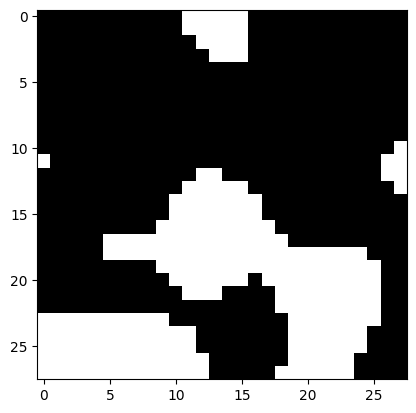

In [ ]:
# The method for generating masks for negative data mentioned by Geoffrey Hinton in the article
def mask_gen(itr = 10):
    random_image = np.random.randint(2, size=(28,28)).squeeze().astype(np.float32)
    blur_filter_horizontal = np.array([[0, 0, 0], [0.25, 0.5, 0.25], [0, 0, 0]])
    blur_filter_vertical = blur_filter_horizontal.T
    for i in range(itr):
        random_image = convolve2d(random_image, blur_filter_vertical, mode='same', boundary='symm')
        random_image = convolve2d(random_image, blur_filter_horizontal, mode='same', boundary='symm')
    # make the mask binerize
    mask = (random_image > 0.5).astype(np.float32)
    return mask

Section B: Generating negative data

In [ ]:
def create_negative_batch(batch):
    mask = mask_gen(8) # mask with 8
    # permute batch twice
    indexes1 = torch.randperm(batch.shape[0])
    indexes2 = torch.randperm(batch.shape[0])
    batch_perm1 = batch[indexes1]
    batch_perm2 = batch[indexes2]
    # apply the mask for each batch
    masked_batch_perm1 = batch_perm1 * mask
    masked_batch_perm2 = batch_perm2 * (1-mask)
    # add masked batches
    hybrid_images = masked_batch_perm2 + masked_batch_perm1
    return hybrid_images

Section C: Implement Network

In [ ]:
class UnNet(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]

    def predict(self, x):
        layers_output = torch.Tensor([]).cuda()
        h = x.clone()
        for layer in self.layers:
            h = layer.forward(h)
            layers_output = torch.cat([layers_output, h],1)
        return layers_output

    def train(self, x_pos, x_neg):
        itr_pos = x_pos.clone()
        itr_neg = x_neg.clone()
        for layer in self.layers:
            itr_pos, itr_neg = layer.train(itr_pos, itr_neg)

خروجی شبکه در این حالت لیبل ها نیست و در واقع یک فیچر مپ از آنها است. یعنی اگر شبکه به خوبی تنظیم شود میتواند ویژگی های خیلی خوبی داشته باشد; از این ویژگی ها میتوان برای طبقه بندی عکس ها استفاده کرد.

Section D: Linear Classifier

زیرا تنها در این صورت میتوان فهمید که ویژگی های خوبی استخراج کرده ایم یا خیر. اگر طبقه بند غیرخطی باشد انگار بخشی از طبقه بند وظیفه استخراج ویژگی را انچام میدهد.

In [ ]:
model_usv = UnNet([784,500,500,500,500])

model_usv.train(images_pos, images_neg)


100%|██████████| 800/800 [00:31<00:00, 25.26it/s]


In [ ]:
class LinearClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.epoch_losses = []
        self.linear = nn.Linear(2000, 10).cuda()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.05)
        self.criterion = nn.CrossEntropyLoss()
        self.softmax = nn.Softmax()

    def forward(self, x):
        return self.linear(x)

    def predict(self, x):
        x = x.view(-1, 784).cuda()
        model_out = model_usv.predict(x)
        classifier_out = self.forward(model_out)
        soft_out = self.softmax(classifier_out)
        return soft_out.argmax()

    def train(self, data_loader, epoch_num):
        linear_loop = tqdm_notebook(range(epoch_num), total=epoch_num)
        for i in linear_loop:
            batch_losses = []
            for batch in iter(data_loader):
                x,y = batch
                x = x.view(-1,784).cuda()
                y_r = nn.functional.one_hot(y, num_classes=10).to(torch.float).cuda()
                model_out = model_usv.predict(x)
                classifier_out = self.forward(model_out)
                loss_batch = self.criterion(classifier_out, y_r) # Cross Entropy loss
                # Optimization
                self.optimizer.zero_grad()
                loss_batch.backward()
                self.optimizer.step()
                # Add the loss to all losses
                batch_losses.append(loss_batch)
            self.epoch_losses.append(float(sum(batch_losses)/len(batch_losses)))

    def test(self, data_loader):
        acc_list = []
        for batch in iter(data_loader):
            x, y = batch
            x = x.view(-1,784).cuda()
            y_r = nn.functional.one_hot(y, num_classes=10).to(torch.float).cuda()
            model_out = model_usv.predict(x)
            classifier_out = self.forward(model_out)
            loss_batch = self.criterion(classifier_out, y_r)

            # Get the index of the max log-probability (predicted class) for each sample
            pred = classifier_out.argmax(dim=1)

            # Get the index of the actual class for each sample
            target = y_r.argmax(dim=1)

            # Calculate the accuracy by comparing predictions with labels
            accuracy = (pred == target).float().mean().item()
            acc_list.append(accuracy)
        return acc_list

Section E: report results

In [ ]:
linear_model = LinearClassification()
losses = linear_model.train(train_loader, 100)
acc = linear_model.test(test_loader)
print(f'Accuracy: {max(acc) * 100}%')
# It takes around 30 minutes, acc = 81 %

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy: 81.2999963760376%
